In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import math

sns.set_theme()

### Task 1

**Item 1**

Python generator of Bernoulli random variable. Able to generate infinitely. 


In [80]:
def bern_gen(p):
    while True:
        if np.random.random() < p:
            yield 1
        else:
            yield 0

Python generator of binominal random variable. Able to generate infinitely.

In [81]:
def bin_gen(p, n):
    bg = bern_gen(p)
    while True:
        sum = 0
        for i in range(n):
            sum += next(bg)
        yield sum

Visualization of binominal distribution with success probability *p* and number of attempts *n*.

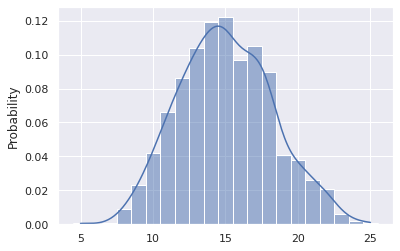

In [215]:
p = 0.3
n = 50
bing = bin_gen(p,n)
N = 1000

values = [next(bing) for i in range(N)]
sns.histplot(data = values, kde = True, kde_kws = {"bw_adjust" : 1}, discrete = True, stat = 'probability')
del p, n, bing, N, values

**Item 2**

Python generator of geometric random variable. Able to generate infinitely.

In [83]:
def geom_gen(p):
    bg = bern_gen(p)
    while True:
        sum = 0
        while not next(bg):
            sum += 1
        yield sum

Visualization of geometric distribution.

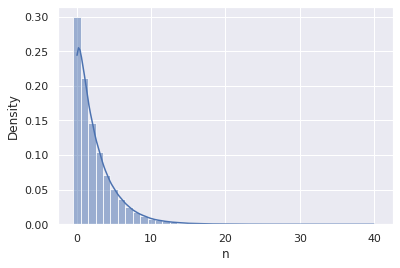

In [84]:
n = 100000
p = 0.3
gg = geom_gen(p)

values = {"n" : [next(gg) for i in range(n)]}
sns.histplot(data = pd.DataFrame(values), x = "n", kde = True, kde_kws = {"bw_adjust" : 2}, discrete = True, stat = 'probability')

del n, p, gg, values

Representation of geometric distribution memoryless property:  $\mathbb{P}(\mathbb{X} > m + n \, | \, \mathbb{X} \geq m) = \mathbb{P}(\mathbb{X} > n) $.  
(Previous cell execution required)

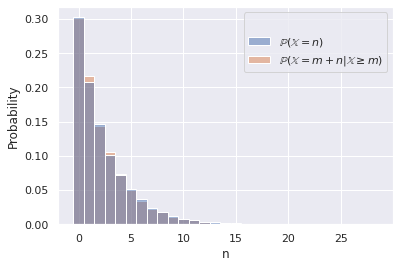

In [85]:
m = 5
n = 100000
p = 0.3
gg = geom_gen(p)

values = {"n" : [next(gg) for i in range(n)]}

values[" "] = r'$\mathbb{P}(\mathbb{X} = n)$'

cutted_values = {"n" : [value - m for value in values["n"] if value >= m]}
cutted_values[" "] = r"$\mathbb{P}(\mathbb{X} = m + n | \mathbb{X} \geq m)$"

df_new_values = pd.concat([pd.DataFrame(values), pd.DataFrame(cutted_values)], ignore_index = True)

sns.histplot(data = df_new_values, x = "n", hue = " ", discrete = True, stat = "probability", common_norm = False)

del n, m, p, gg, values, cutted_values, df_new_values

**Item 3**

Trajectory of $ Y(i) = \dfrac{X_1 + X_2 + \dots + X_i}{\sqrt{n}} $, where $ \mathbb{P}(X_i = 1) = \mathbb{P}(X_i = -1) = \dfrac{1}{2}, \quad i = 1, \dots, n $

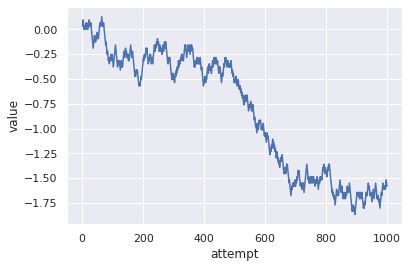

In [86]:
rng = np.random.default_rng()

n = 1000
df = pd.DataFrame(dict(attempt = np.arange(1, n + 1), value = rng.choice(np.array([-1, 1]), n).cumsum() / math.sqrt(n)))
sns.lineplot(x = "attempt", y = "value", data = df)
del rng, n, df

### Task 2

**Item 1**

Python generator for Cantor random variable. Generates list with random variable value and distrubution function at this point.

In [87]:
def cantor_gen(eps):
    bg = bern_gen(0.5)
    n = math.ceil(- math.log(eps, 3))
    while True:
        rand_val = 0
        dis_func = 0
        for i in np.arange(1,n + 1):
            bern = next(bg)
            rand_val += 2 / 3**i * bern
            dis_func += 1 / 2**i * bern    
        yield [rand_val, dis_func]

Kolmogorov distribution function. $ K = 1 + 2 \displaystyle\sum_{k = 1}^{\infty}(-1)^k e^{-2k^2x^2} $

In [88]:
def K(x):
    n = 10000
    sum = 0
    for k in np.arange(1, n + 1):
        sum += (-1)**k * math.e ** (-2 * k**2 * x**2)
    return 1 + 2 * sum

Kolmogorov criteria function. Accepts vector with values of theoretical distribution function in selected points `dist_function` and significance level `alpha`. $D_n $ here is computed using formula: $ D_n(x_1, \dots, x_n) = \displaystyle\max_{1 \le i \le n} \left\{ \dfrac{i}{n} - F(x_{(i)}), F(x_{(i)}) - \dfrac{i - 1}{n} \right\}. $  

In [89]:
def kolmogorov(dist_function, alpha):
    n = dist_function.size
    sorted_dist_function = sorted(dist_function)
    maxes = np.zeros(n)
    for i in np.arange(1, n + 1):
        maxes[i - 1] = max(i / n - sorted_dist_function[i - 1], sorted_dist_function[i - 1] - (i - 1)/n)
    D_n = max(maxes)

    if 1 - K(math.sqrt(n) * D_n) > alpha:
        return True
    else:
        return False

Distribution function of generated Cantor random variable and verification using Kolmogorov criteria.

accordance: True


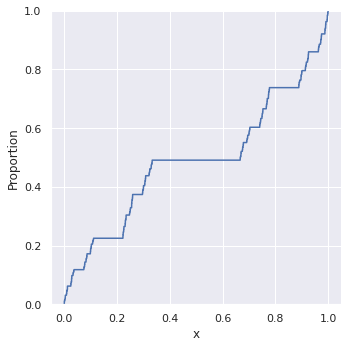

In [90]:
n = 1000
cg = cantor_gen(0.0001)
selection = np.zeros(n)
dist_function = np.zeros(n)

for i in range(n):
    new_cantor_vec = next(cg)
    selection[i] = new_cantor_vec[0]
    dist_function[i] = new_cantor_vec[1]

df = pd.DataFrame({"x" : selection})
sns.displot(data = df, x = "x", kind = "ecdf")

alpha = 0.05
print("accordance:", kolmogorov(dist_function, 0.05))

del n, cg, selection, new_cantor_vec, dist_function, i, df, alpha

**Item 2**

Computation of empirical distribution function of `selection` in `value` point. $ \hat{F}_n (x) = \dfrac{1}{n} \displaystyle\sum_{i = 1}^n \mathbb{I}(x_i < x) $

In [91]:
def F_hat(selection, value):
    number_less = 0
    for val in selection:
        if val <= value:
            number_less += 1
    return number_less / selection.size

Smirnov criteria function. Accepts two selections `x` and `y`, and significance level `alpha`. $ D_{n,m} = \max \left\{ D_{n,m}^+, D_{n,m}^- \right\}$, где $ D_{n,m}^+ = \displaystyle\sup_{x}(\hat{F}_n(x) - \hat{G}_m(x)) = \displaystyle\max_{1 \le i \le n} \left\{ \frac{i}{n} - \hat{G}_m(x_{(i)}) \right\}, D_{n,m}^- = \displaystyle\sup_{x}(\hat{G}_m(x) - \hat{F}_n(x)) = \displaystyle\max_{1 \le j \le m} \left\{ \frac{j}{m} - \hat{F}_n(y_{(j)}) \right\}. $ Uses $ K(x) $ function.

In [92]:
def smirnov(x,y, alpha):
    n = x.size
    m = y.size
    x.sort()
    y.sort()
    maxes_plus = np.zeros(n)
    maxes_minus = np.zeros(m)
    for i in np.arange(1, n + 1):
        maxes_plus[i - 1] = i / n -  F_hat(y, x[i - 1])
    D_plus = max(maxes_plus)

    for i in np.arange(1, m + 1):
        maxes_minus[i - 1] = i/m - F_hat(x, y[i - 1])
    D_minus = max(maxes_minus)

    D_n_m = max(D_plus, D_minus)
    
    if 1 - K(math.sqrt(n * m / (n + m)) * D_n_m) > alpha:
        return True
    else:
        return False

Cheking uniformity of $ X $ and $ 1 - X $ using Smirnov criteria.

uniformity: True


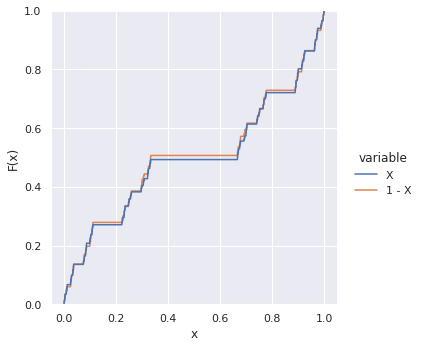

In [93]:
n = 1000
cg = cantor_gen(0.0001)
x = np.zeros(n)
y = np.zeros(n)
alpha = 0.05

for i in range(n):
    x[i] = next(cg)[0]

y = 1 - x

x_values = {"value" : x}
x_values["variable"] = "X"

y_values = {"value" : y}
y_values["variable"] = "1 - X"

df = pd.concat([pd.DataFrame(x_values), pd.DataFrame(y_values)], ignore_index = True)

graph = sns.displot(data = df, x = "value", hue = "variable", kind = "ecdf")
graph.set_axis_labels("x", "F(x)")

print("uniformity:", smirnov(x,y,alpha))

del n, cg, x, y, alpha, i, x_values, y_values, df, graph

Cheking uniformity of $ X | X \in [0;\dfrac{1}{3}] $ and $ \dfrac{X}{3} $

uniformity: True


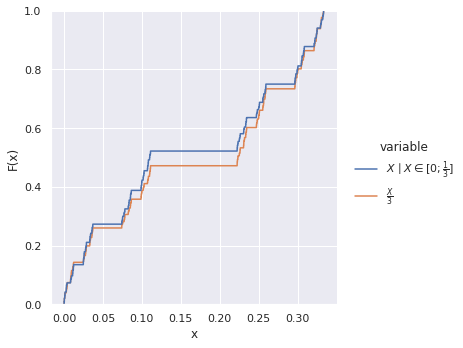

In [94]:
n = 1000
cg = cantor_gen(0.0001)
x = np.zeros(n)
y = np.zeros(n)
alpha = 0.05

for i in range(n):
    x[i] = next(cg)[0]
    y[i] = x[i] / 3
    if x[i] >= 2/3:
        x[i] -= 2/3

x_values = {"value" : x}
x_values["variable"] = r"$X \mid X \in [0;\frac{1}{3}]$"

y_values = {"value" : y}
y_values["variable"] = r"$\frac{X}{3}$"

df = pd.concat([pd.DataFrame(x_values), pd.DataFrame(y_values)], ignore_index = True)

graph = sns.displot(data = df, x = "value", hue = "variable", kind = "ecdf")
graph.set_axis_labels("x", "F(x)")

print("uniformity:", smirnov(x,y,alpha))

del n, cg, x, y, alpha, i, x_values, y_values, df, graph

**Item 3**

Illustration of convergence of sample mean and dispersion values to their theoretical analogues.

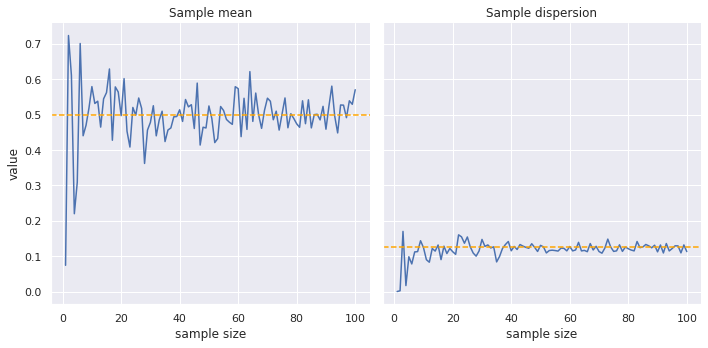

In [95]:
N = 100
cg = cantor_gen(0.001)
E_emp = np.zeros(N)
D_emp = np.zeros(N)
for n in np.arange(1, N + 1):
    selection = [next(cg)[0] for j in range(n)]
    E_n = sum(selection)/n
    D_n = sum((np.array(selection) - E_n)**2) / n
    E_emp[n-1] = E_n
    D_emp[n-1] = D_n

df_E = pd.DataFrame({"size" : np.arange(1, N + 1), "value" : E_emp, "type" : "mean"})
df_D = pd.DataFrame({"size" : np.arange(1, N + 1), "value" : D_emp, "type" : "dispersion"})
df = pd.concat([df_E, df_D], ignore_index = True)

graph = sns.relplot(x = "size", y = "value", data = df, kind = "line", col = "type")
ax1, ax2 = graph.axes[0]
ax1.axhline(0.5, ls='--', color = 'orange')
ax2.axhline(0.125, ls='--', color = 'orange')
graph.set_axis_labels("sample size", "value")
graph.set_titles("Sample {col_name}")

del N, cg, E_emp, D_emp, D_n, E_n, selection, n, df_E, df_D, df, graph, ax1, ax2

### Task 3

**Item 1**

Inversed distribution function of exponential distribution: $F^{-1}(y) = -\dfrac{1}{\lambda} \ln(1 - y) $.

In [96]:
def inv_exp_func(x, lam):
    return -1/lam * np.log(1 - x)

Python generator of exponential distribution.

In [97]:
def exp_gen(lam):
    while True:
        yield inv_exp_func(np.random.random(), lam)

Probability density function of exponential distribution: $ p(x) = \lambda e^{-\lambda x} $

In [98]:
def p_exp(lam, x):
    return lam * np.e**(-lam * x)

Visulization of exponential distrubution.

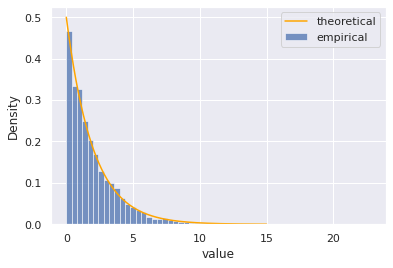

In [99]:
n = 10000
lam = 0.5
eg = exp_gen(lam)

values = {"value" : [next(eg) for i in range(n)]}
graph = sns.histplot(data = pd.DataFrame(values), x = "value", label = "empirical", binwidth = 0.4, stat = 'density')
sns.lineplot(x = np.linspace(0, 15, 1000), y = p_exp(lam, np.linspace(0, 15, 1000)), color = "orange", label = "theoretical", ax = graph)

del n, lam, eg, values, graph

Representation of exponential distribution memoryless property: $ \mathbb{P}(X \ge s + t \mid X \ge t) = \mathbb{P}(X \ge s) $.  
(Previous cell execution required)

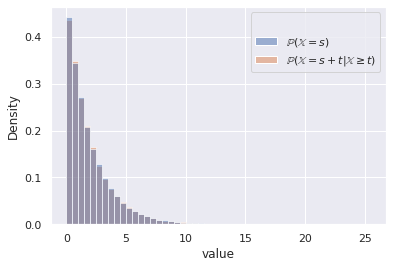

In [100]:
t = 2
n = 100000
lam = 0.5
eg = exp_gen(lam)

values = {"value" : [next(eg) for i in range(n)]}

values[" "] = r'$\mathbb{P}(\mathbb{X} = s)$'

cutted_values = {"value" : [value - t for value in values["value"] if value >= t]}
cutted_values[" "] = r"$\mathbb{P}(\mathbb{X} = s + t | \mathbb{X} \geq t)$"

df_new_values = pd.concat([pd.DataFrame(values), pd.DataFrame(cutted_values)], ignore_index = True)

sns.histplot(data = df_new_values, x = "value", hue = " ", binwidth = 0.5, stat = "density", common_norm = False)

del n, t, eg, values, cutted_values, df_new_values

Distribution of $ Y = \min(X_1, X_2, \dots, X_n) $, where $ X_i \sim \mathrm{Exp}(\lambda_i) $.

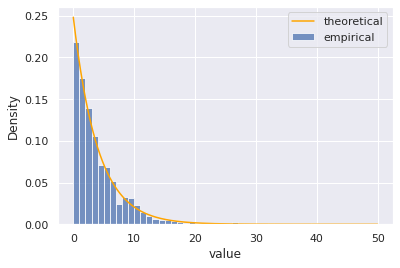

In [204]:
n = 4
N = 1000
lam = [0.1 * np.random.random() for i in range(n)]
eg = [exp_gen(l) for l in lam]
Y = np.zeros(N)
for i in range(N):
    Y[i] = min([next(eg[j]) for j in range(n)])

values = {"value" : Y}
graph = sns.histplot(data = values, x = "value", binwidth = 1, label = "empirical", stat = 'density')
sns.lineplot(x = np.linspace(0, 50, 1000), y = p_exp(sum(lam), np.linspace(0, 50, 1000)), color = "orange", label = "theoretical", ax = graph)

del i, n, N, lam, eg, Y, graph, values

**Item 2**

Poisson distribution generator. Uses exponential distribution generator.

In [187]:
def pois_gen(lam):
    eg = exp_gen(lam)
    while True:
        sum = 0
        count = 0
        while sum < 1:
            sum += next(eg)
            count += 1
        if count > 1:
            yield count - 1
        else:
            yield 0

Poisson density function: $ p(k) = \dfrac{\lambda^k e^{-\lambda}}{k!} $.

In [188]:
def p_pois(lam, k):
    return lam**k * np.e**(-lam) / sp.special.factorial(k)

Visualization of Poisson distribution.

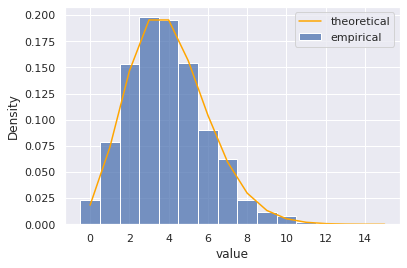

In [212]:
n = 1000
lam = 4
pg = pois_gen(lam)

values = {"value" : [next(pg) for i in range(n)]}
graph = sns.histplot(data = values, x = "value", label = "empirical", discrete = True, stat = 'probability')
sns.lineplot(x = np.linspace(0, 15, 16), y = p_pois(lam, np.linspace(0, 15, 16)), color = "orange", label = "theoretical", ax = graph)

del n, lam, pg, values, graph

**Item 3**

Generator of Poisson distribution as limit of binominal distribution.  
$ (n = 10000) $

In [206]:
def binlimit_gen(lam):
    n = 10000
    while True:
        bing = bin_gen(lam/n, n)
        yield next(bing)

Binominal distribution with $ n = 10000 $ and $ p = \dfrac{\lambda}{n} $ compared to theoretical Poisson distribution.

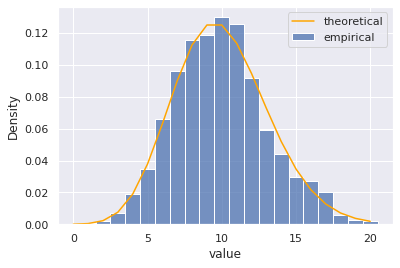

In [214]:
N = 1000
lam = 10
blg = binlimit_gen(lam)
values = {"value" : [next(blg) for i in range(N)]}
graph = sns.histplot(data = values, x = "value", label = "empirical", discrete = True, stat = 'probability')
sns.lineplot(x = np.linspace(0, 20, 21), y = p_pois(lam, np.linspace(0, 20, 21)), color = "orange", label = "theoretical", ax = graph)

del N, lam, blg, values, graph